In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from copy import deepcopy

In [2]:
chirps_file = "../Data/vietnam/fluvial_defended/FD_1in5.csv"
chirps_ori = pd.read_csv(chirps_file)
chirps_ori.dropna(inplace=True)
chirps_ori.columns = ['Lon', 'Lat', 'flood_level']

In [3]:
chirps_data = deepcopy(chirps_ori)
chirps_data.describe()

,Lon,Lat,flood_level
count,3.742867e+06,3.742867e+06,3.742867e+06
mean,1.068656e+02,1.488037e+01,7.547060e+02
std,1.573846e+00,4.615944e+00,4.290550e+02
min,1.021692e+02,8.366667e+00,1.000023e-02
25%,1.056708e+02,1.041250e+01,9.990000e+02
50%,1.068033e+02,1.379167e+01,9.990000e+02
75%,1.080667e+02,2.007250e+01,9.990000e+02
max,1.095075e+02,2.316583e+01,9.990000e+02


In [4]:
# remove permanent water body to reduce calculation time
chirps_data = chirps_data.where(chirps_data['flood_level'] < 999)
# chirps_data.dropna(inplace=True)
# chirps_data.reset_index(drop=True, inplace=True)

In [5]:
chirps_data['Lon'] = chirps_data['Lon'].apply(lambda x: round(x, 3))
chirps_data['Lat'] = chirps_data['Lat'].apply(lambda x: round(x, 3))

In [6]:
# as we round the coordinates, there exist duplicate coordinate pairs with different flood level
# I use max to emphasize the severity of the flood chance
aggregation_functions = {'flood_level': 'max'}
chirps_data = chirps_data.groupby(['Lon', 'Lat']).aggregate(aggregation_functions)

In [7]:
chirps_data.describe()

,flood_level
count,682664.000000
mean,1.215324
std,1.741641
min,0.010000
25%,0.138520
50%,0.513068
75%,1.552063
max,10.000000


In [8]:
facs_file = "../Data/stroke-facs.csv"
stroke_data = pd.read_csv(facs_file)[['Name_English','longitude','latitude','pro_name_e','dis_name_e']]
stroke_data.columns = ['Facility_Name','Lon','Lat','Province','District']
stroke_data['Lon'] = stroke_data['Lon'].apply(lambda x: round(x, 3))
stroke_data['Lat'] = stroke_data['Lat'].apply(lambda x: round(x, 3))

In [9]:
stroke_data[:10]

,Facility_Name,Lon,Lat,Province,District
0,115 People's Hospital,106.667,10.775,Ho Chi Minh City,District 10
1,University Medical Center HCMC-Branch 1,106.664,10.756,Ho Chi Minh City,District 5
2,Nhan Dan Gia Dinh Hospital,106.694,10.804,Ho Chi Minh City,Binh Thanh District
3,Nguyen Tri Phuong Hospital,106.670,10.755,Ho Chi Minh City,District 5
4,Thu Duc District Hospital,106.745,10.865,Ho Chi Minh City,Thu Duc District
5,An Binh Hospital,106.671,10.755,Ho Chi Minh City,District 5
6,Thong Nhat Hospital,106.653,10.792,Ho Chi Minh City,Tan Binh District
7,District 2 General Hospital,106.768,10.782,Ho Chi Minh City,District 2
8,Hoan My Saigon Hospital (CS1) Hoan My Group,106.684,10.800,Ho Chi Minh City,Phu Nhuan District
9,Tan Phu District Hospital,106.642,10.784,Ho Chi Minh City,Tan Phu District


In [10]:
# merge two dataset to see the flood level for each facility
facs_w_flood = stroke_data.merge(chirps_data, how='left', on=['Lon', 'Lat']).fillna(0)
# sort descendingly and retrieve the top 10 - the wort quartile
facs_w_flood.sort_values('flood_level', ascending=False).reset_index(drop=True).head(10)

,Facility_Name,Lon,Lat,Province,District,flood_level
0,105 Military Hospital,105.496,21.117,Ha Noi,Son Tay Town,1.210347
1,Vinh Phuc Provincial General Hospital,105.600,21.319,Vinh Phuc,Vinh Yen City,0.802787
2,115 People's Hospital,106.667,10.775,Ho Chi Minh City,District 10,0.000000
3,Nam Dinh Provincial General Hospital,106.172,20.426,Nam Dinh,Nam Dinh City,0.000000
4,Hue Central Hospital,107.586,16.463,Thua Thien Hue,Hue City,0.000000
5,Quang Tri Provincial General Hospital,107.109,16.810,Quang Tri,Dong Ha City,0.000000
6,Ha Tinh Provincial General Hospital,105.895,18.344,Ha Tinh,Ha Tinh City,0.000000
7,Nghe An Friendship Hospital (provincial general),105.701,18.685,Nghe An,Vinh City,0.000000
8,Hop Luc General Hospital,105.778,19.828,Thanh Hoa,Thanh Hoa City,0.000000
9,Thanh Hoa Provincial General Hospital\r\n,105.771,19.776,Thanh Hoa,Thanh Hoa City,0.000000


In [11]:
# Prepare the template df to merge remaining data
flood_chance_facs = deepcopy(facs_w_flood)
flood_chance_facs.columns  = ['Facility_Name','Lon','Lat','Province','District', 'FD_5yrs_level']

In [12]:
# finalize the merged dataframe into a function for modularization
def flood_stroke_facs(file_name, col_name, full_df):
    file_data = pd.read_csv(file_name)
    file_data.dropna(inplace=True)
    file_data.columns = ['Lon', 'Lat', col_name]
    file_data = file_data.where(file_data[col_name] < 999)
    file_data['Lon'] = file_data['Lon'].apply(lambda x: round(x, 3))
    file_data['Lat'] = file_data['Lat'].apply(lambda x: round(x, 3))
    aggregation_functions = {col_name: 'max'}
    file_data = file_data.groupby(['Lon', 'Lat']).aggregate(aggregation_functions)
    new_df = full_df.merge(file_data, how='left', on=['Lon', 'Lat']).fillna(0)
    return new_df

In [13]:
file_dict = {'FD_10yrs_level': "../Data/vietnam/fluvial_defended/FD_1in10.csv",
            'FD_20yrs_level': "../Data/vietnam/fluvial_defended/FD_1in20.csv",
            'FD_50yrs_level': "../Data/vietnam/fluvial_defended/FD_1in50.csv",
            'FD_75yrs_level': "../Data/vietnam/fluvial_defended/FD_1in75.csv",
            'FD_100yrs_level': "../Data/vietnam/fluvial_defended/FD_1in100.csv",
            'FD_200yrs_level': "../Data/vietnam/fluvial_defended/FD_1in200.csv",
            'FD_250yrs_level': "../Data/vietnam/fluvial_defended/FD_1in250.csv",
            'FD_500yrs_level': "../Data/vietnam/fluvial_defended/FD_1in500.csv",
            'FD_1000yrs_level': "../Data/vietnam/fluvial_defended/FD_1in1000.csv",
            'FU_5yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in5.csv",
            'FU_10yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in10.csv",
            'FU_20yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in20.csv",
            'FU_50yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in50.csv",
            'FU_75yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in75.csv",
            'FU_100yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in100.csv",
            'FU_200yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in200.csv",
            'FU_250yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in250.csv",
            'FU_500yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in500.csv",
            'FU_1000yrs_level': "../Data/vietnam/fluvial_undefended/FU_1in1000.csv",
            }
from tqdm import tqdm
# process all data files from CHIRPS
for flood_case in tqdm(file_dict.keys()):
    flood_chance_facs = flood_stroke_facs(file_dict[flood_case], flood_case, flood_chance_facs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [04:32<00:00, 14.35s/it]


In [14]:
# Facilities in the worst quartile of having flood in the next 5 yrs with no flood defense mechanism
flood_chance_facs.sort_values('FU_5yrs_level', ascending=False, inplace=True)
flood_chance_facs.reset_index(drop=True).head(5)

,Facility_Name,Lon,Lat,Province,District,FD_5yrs_level,FD_10yrs_level,FD_20yrs_level,FD_50yrs_level,FD_75yrs_level,...,FU_5yrs_level,FU_10yrs_level,FU_20yrs_level,FU_50yrs_level,FU_75yrs_level,FU_100yrs_level,FU_200yrs_level,FU_250yrs_level,FU_500yrs_level,FU_1000yrs_level
0,105 Military Hospital,105.496,21.117,Ha Noi,Son Tay Town,1.210347,1.485618,1.818788,2.390887,2.691090,...,2.774692,3.260604,3.771004,4.515856,4.823818,5.038204,5.561271,5.749408,6.437646,7.303931
1,Hue Central Hospital,107.586,16.463,Thua Thien Hue,Hue City,0.000000,0.000000,1.109653,1.767806,2.052960,...,0.863429,1.233394,1.531653,1.906917,2.067290,2.182488,2.465560,2.559875,2.865908,3.197657
2,Ninh Thuan provincial General Hospital,108.990,11.565,Ninh Thuan,Phan Rang-Thap Cham City,0.000000,0.000000,0.000000,0.339149,0.582832,...,0.689802,0.969340,1.150892,1.292702,1.340520,1.371759,1.533899,1.644441,2.021450,2.441891
3,Xuyen A General Hospital (BVXA-HCMC),106.558,10.927,Ho Chi Minh City,Cu Chi District,0.000000,0.000000,0.000000,0.751995,1.148444,...,0.480041,1.143957,1.662842,2.244063,2.393930,2.480590,2.677887,2.754376,2.980071,3.202301
4,Vinh Phuc Provincial General Hospital,105.600,21.319,Vinh Phuc,Vinh Yen City,0.802787,1.573727,2.569375,3.791340,4.316658,...,0.169330,0.792047,1.492687,2.562480,3.086312,3.597692,4.681442,4.965717,5.809784,6.677750


<AxesSubplot:title={'center':'Number of stroke facilities in future flooded area'}, xlabel='Years into the future', ylabel='Number of affected facilities country wide'>

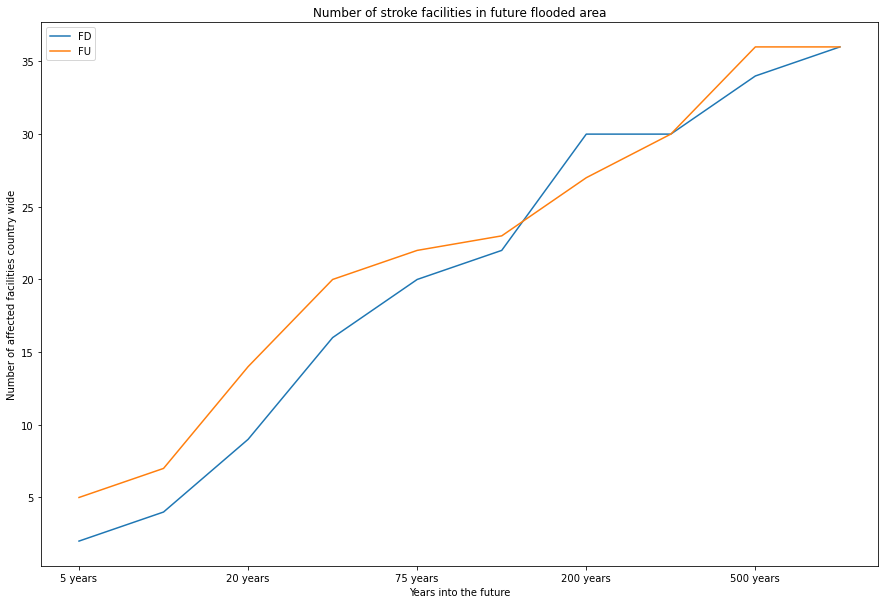

In [30]:
# list all flood cases
all_flood_cases = ['FD_5yrs_level']+ list(file_dict.keys())

# count the number of affected facilities in each group of flood cases: defended vs. undefended
fd_affected_count = []
fu_affected_count = []
for flood_case in all_flood_cases:
    affected_facs = flood_chance_facs[flood_chance_facs[flood_case] != 0].shape[0]
    if 'FD' in flood_case:
        fd_affected_count.append(affected_facs)
    else:
        fu_affected_count.append(affected_facs)
        
# reform the data for presentation
affected_df = pd.DataFrame({'FD': fd_affected_count,
                            'FU': fu_affected_count})
affected_df.index=['5 years', '10 years', '20 years', '50 years', '75 years', '100 years', '200 years', '250 years', '500 years', '1000 years', ]
affected_df.plot.line(title='Number of stroke facilities in future flooded area', figsize=(15, 10),
                      xlabel='Years into the future', ylabel='Number of affected facilities country wide')

In [16]:
# extract FB's population data
fb_pop_data = pd.read_csv('../Data/population_vnm_2018-10-01(Facebook).csv')
fb_pop_data.head(10)

,latitude,longitude,population_2015,population_2020
0,8.564583,104.832361,7.462457,7.582185
1,8.567083,104.840417,7.462457,7.582185
2,8.567083,104.840694,7.462457,7.582185
3,8.567361,104.840694,7.462457,7.582185
4,8.568194,104.840417,7.462457,7.582185
5,8.568194,104.842361,7.462457,7.582185
6,8.568472,104.842639,7.462457,7.582185
7,8.569028,104.840972,7.462457,7.582185
8,8.570417,104.842083,7.462457,7.582185
9,8.570694,104.842083,7.462457,7.582185


In [17]:
# rounding the longitude and latitude for easier calculation
fb_pop_data.columns = ['Lat', 'Lon','Pop_2015','Pop_2020']
fb_pop_data['Lon'] = fb_pop_data['Lon'].apply(lambda x: round(x, 3))
fb_pop_data['Lat'] = fb_pop_data['Lat'].apply(lambda x: round(x, 3))

In [18]:
# aggregation to combine rounded results
aggregation_functions = {'Pop_2015': 'sum','Pop_2020': 'sum'}
agg_fb_pop_data = fb_pop_data.groupby(['Lat', 'Lon']).aggregate(aggregation_functions)
agg_fb_pop_data.head(10)

Pop_2015   Pop_2020
Lat   Lon                          
8.565 104.832   7.462457   7.582185
8.567 104.840   7.462457   7.582185
      104.841  14.924913  15.164370
8.568 104.840   7.462457   7.582185
      104.842   7.462457   7.582185
      104.843   7.462457   7.582185
8.569 104.841   7.462457   7.582185
8.570 104.842   7.462457   7.582185
8.571 104.823   7.462457   7.582185
      104.842   7.462457   7.582185

In [19]:
# merge two dataset to see the effect of flood onto the population within certain stroke facilities
flood_facs_w_pop = flood_chance_facs.merge(agg_fb_pop_data, how='left', on=['Lon', 'Lat']).fillna(0)
flood_facs_w_pop[['Facility_Name','Lon','Lat', 'FD_5yrs_level', 'FU_5yrs_level', 'Pop_2020']]

,Facility_Name,Lon,Lat,FD_5yrs_level,FU_5yrs_level,Pop_2020
0,105 Military Hospital,105.496,21.117,1.210347,2.774692,82.065298
1,Hue Central Hospital,107.586,16.463,0.000000,0.863429,71.288856
2,Ninh Thuan provincial General Hospital,108.990,11.565,0.000000,0.689802,92.294804
3,Xuyen A General Hospital (BVXA-HCMC),106.558,10.927,0.000000,0.480041,25.340040
4,Vinh Phuc Provincial General Hospital,105.600,21.319,0.802787,0.169330,59.895782
...,...,...,...,...,...,...
75,Hospital 7A - Quân khu 7,106.671,10.755,0.000000,0.000000,571.890400
76,Tam Duc Heart Hospital,106.718,10.734,0.000000,0.000000,30.380959
77,District 1 Health Center (CS1-hospital),106.689,10.790,0.000000,0.000000,755.597148
78,Tan Binh District Health Center (CS1-Hospital),106.655,10.794,0.000000,0.000000,376.937095


<AxesSubplot:title={'center':'Population within stroke facilities in top quintiles of flood chance'}, xlabel='Years into the future', ylabel='Number of affected Pop in 2020 (in thousand)'>

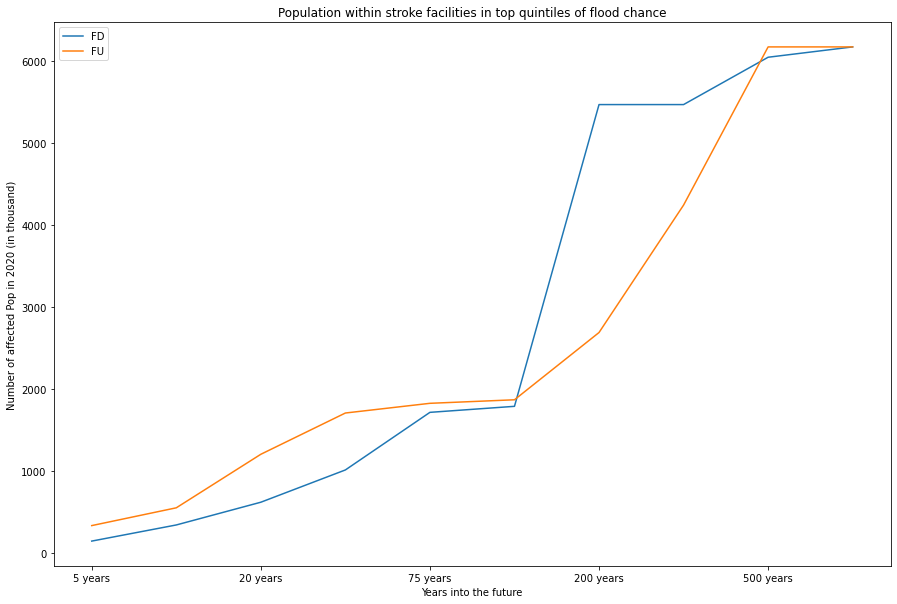

In [31]:
fd_pop_affected_count = []
fu_pop_affected_count = []
# will only extract top 16 - worst quintiles
for flood_case in all_flood_cases:
    worst_quartile_df = flood_facs_w_pop.sort_values(flood_case, ascending=False)[:16]
    affected_pop = sum(flood_facs_w_pop[flood_facs_w_pop[flood_case] != 0]['Pop_2020'].to_numpy())
    if 'FD' in flood_case:
        fd_pop_affected_count.append(affected_pop)
    else:
        fu_pop_affected_count.append(affected_pop)

# form data for presentation
affected_pop_df = pd.DataFrame({'FD': fd_pop_affected_count,
                                'FU': fu_pop_affected_count})
affected_pop_df.index=['5 years', '10 years', '20 years', '50 years', '75 years', '100 years', '200 years', '250 years', '500 years', '1000 years', ]
affected_pop_df.plot.line(title='Population within stroke facilities in top quintiles of flood chance',
                          figsize=(15, 10), xlabel='Years into the future',
                          ylabel='Number of affected Pop in 2020 (in thousand)')